Final Project
================
Collaborators: 
* Brian Demyan
* Alan Fuentes

In [23]:
# remove this line before commit
import sys
print(sys.executable)

c:\Users\Alan\AppData\Local\Programs\Python\Python311\python.exe


Frame the Problem and Look at the Big Picture
=====================================

1. **Define the objective in business terms:** Hired by the United States Department of Transportation in order to evaluate the factors which contribute to severe accidents, and in turn, longer traffic jams/delays. The US DoT is embarking on a project to address the most impactful factors, sparked by a new presidential administration's initiative to reduce automotive accident-related fatalities. The new administration has also championed initiatives to reduce traffic congestion across the United States by revamping automotive infrastructure (roads, highways, traffic control systems, etc.). The US DoT's project would effectively tie two loose ends at once. The US DoT requires an effective solution in order to correctly allocate resources to this issue. Their success in this endeavor will determine whether the DoT will see increases to their current budget or budget cuts.

2. **How will your solution be used?** It will be used in a pipeline to determine the factors that cause severe accidents/longer traffic delays so the DoT can allocate resources to their automotive safety/traffic decongestion project. It will periodically process new data at an annual rate after new yearly analytical summary data is released.

3. **How is a solution being used?** Currently no solution for this is used, the next step simply does not utilize this information and mostly relies on longer-term information. 

4. **How should you frame this problem?** This will be a supervised, binary classification problem where we are predicting which factors contribute to severe accidents/traffic delays. As the client only requires the information to be updated infrequently after new yearly data has been obtained, offline batch learning will be used. 

5. **How should performance be measured? Is the performance measure aligned with the business objective?** Performance will be measured using the F1 score, as we want to minimize false positives (predicting a severe accident/delay when there is none) and false negatives (missing actual severe accidents/delays). 

6. **What would be the minimum performance needed to reach the business objective?** The minimum should be an F1 score of 0.70, as anything below that might result in a system that fails to effectively predict severe accidents/delays or causes too many false alerts.

7. **What are comparable problems? Can you reuse (personal or readily available) experience or tools?** A similar classification problem would be the early spring and diseased squirrel analyses, as they were both binary classification problems.

8. **Is human expertise available?** The client is providing information they have compiled, but no previous work on this specific matter has been conducted.

9. **How would you solve the problem manually?** I would create a function to parse through the automotive accident data and return the counts of unique contributing factors in descending order in order to begin investigating them.

10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.** 

* The period of data used (2016-2023) contains typical data (relative to historical records) and is not affected by some sort of short-term influence. 
* Recorded data and its units are accurate
* The data pertains to only the listed 49 states in the United States

In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score, train_test_split

import scipy
import pandas as pd
from pandas import read_csv
import matplotlib.pylab as plot
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler, LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.cluster import DBSCAN

from sklearn import set_config
set_config(transform_output = "pandas")

Get the Data
================

1. **List the data you need and how much you need:**
2. **Find and document where you can get that data:**
3. **Get access authorizations**: None needed, publicy available.
4. **Create a workspace**: This notebook.
5. **Get the data**: 
6. **Convert the data to a format you can easily manipulate**: 
7. **Ensure sensitive information is deleted or protected**: Public data already has been anonymized.
8. **Check the size and type of data (time series, geographical, …)**: Done below.
9. **Sample a test set, put it aside, and never look at it (no data snooping!)**

In [2]:
# Load accident data 
accidents = read_csv('US_Accidents_March23_sampled_500k.csv')

In [ ]:
# interesting copilot line, not running yet
#accidents = accidents.dropna(subset=['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Weather_Condition'])

In [3]:
accidents.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     500000 non-null  object 
 1   Source                 500000 non-null  object 
 2   Severity               500000 non-null  int64  
 3   Start_Time             500000 non-null  object 
 4   End_Time               500000 non-null  object 
 5   Start_Lat              500000 non-null  float64
 6   Start_Lng              500000 non-null  float64
 7   End_Lat                279623 non-null  float64
 8   End_Lng                279623 non-null  float64
 9   Distance(mi)           500000 non-null  float64
 10  Description            499999 non-null  object 
 11  Street                 499309 non-null  object 
 12  City                   499981 non-null  object 
 13  County                 500000 non-null  object 
 14  State                  500000 non-nu

In [4]:
accidents["Wind_Direction"].value_counts()

Wind_Direction
CALM        62259
S           27182
W           24976
SSW         24805
WNW         24328
Calm        24022
NW          23889
SW          23648
WSW         22869
SSE         22644
NNW         21579
N           19947
SE          19156
E           17971
ESE         17185
NE          16880
ENE         16683
NNE         16639
VAR         16232
South       11371
West        10703
North        9857
Variable     7406
East         6572
Name: count, dtype: int64

array([[<Axes: title={'center': 'Severity'}>,
        <Axes: title={'center': 'Start_Lat'}>,
        <Axes: title={'center': 'Start_Lng'}>,
        <Axes: title={'center': 'End_Lat'}>],
       [<Axes: title={'center': 'End_Lng'}>,
        <Axes: title={'center': 'Distance(mi)'}>,
        <Axes: title={'center': 'Temperature(F)'}>,
        <Axes: title={'center': 'Wind_Chill(F)'}>],
       [<Axes: title={'center': 'Humidity(%)'}>,
        <Axes: title={'center': 'Pressure(in)'}>,
        <Axes: title={'center': 'Visibility(mi)'}>,
        <Axes: title={'center': 'Wind_Speed(mph)'}>],
       [<Axes: title={'center': 'Precipitation(in)'}>, <Axes: >,
        <Axes: >, <Axes: >]], dtype=object)

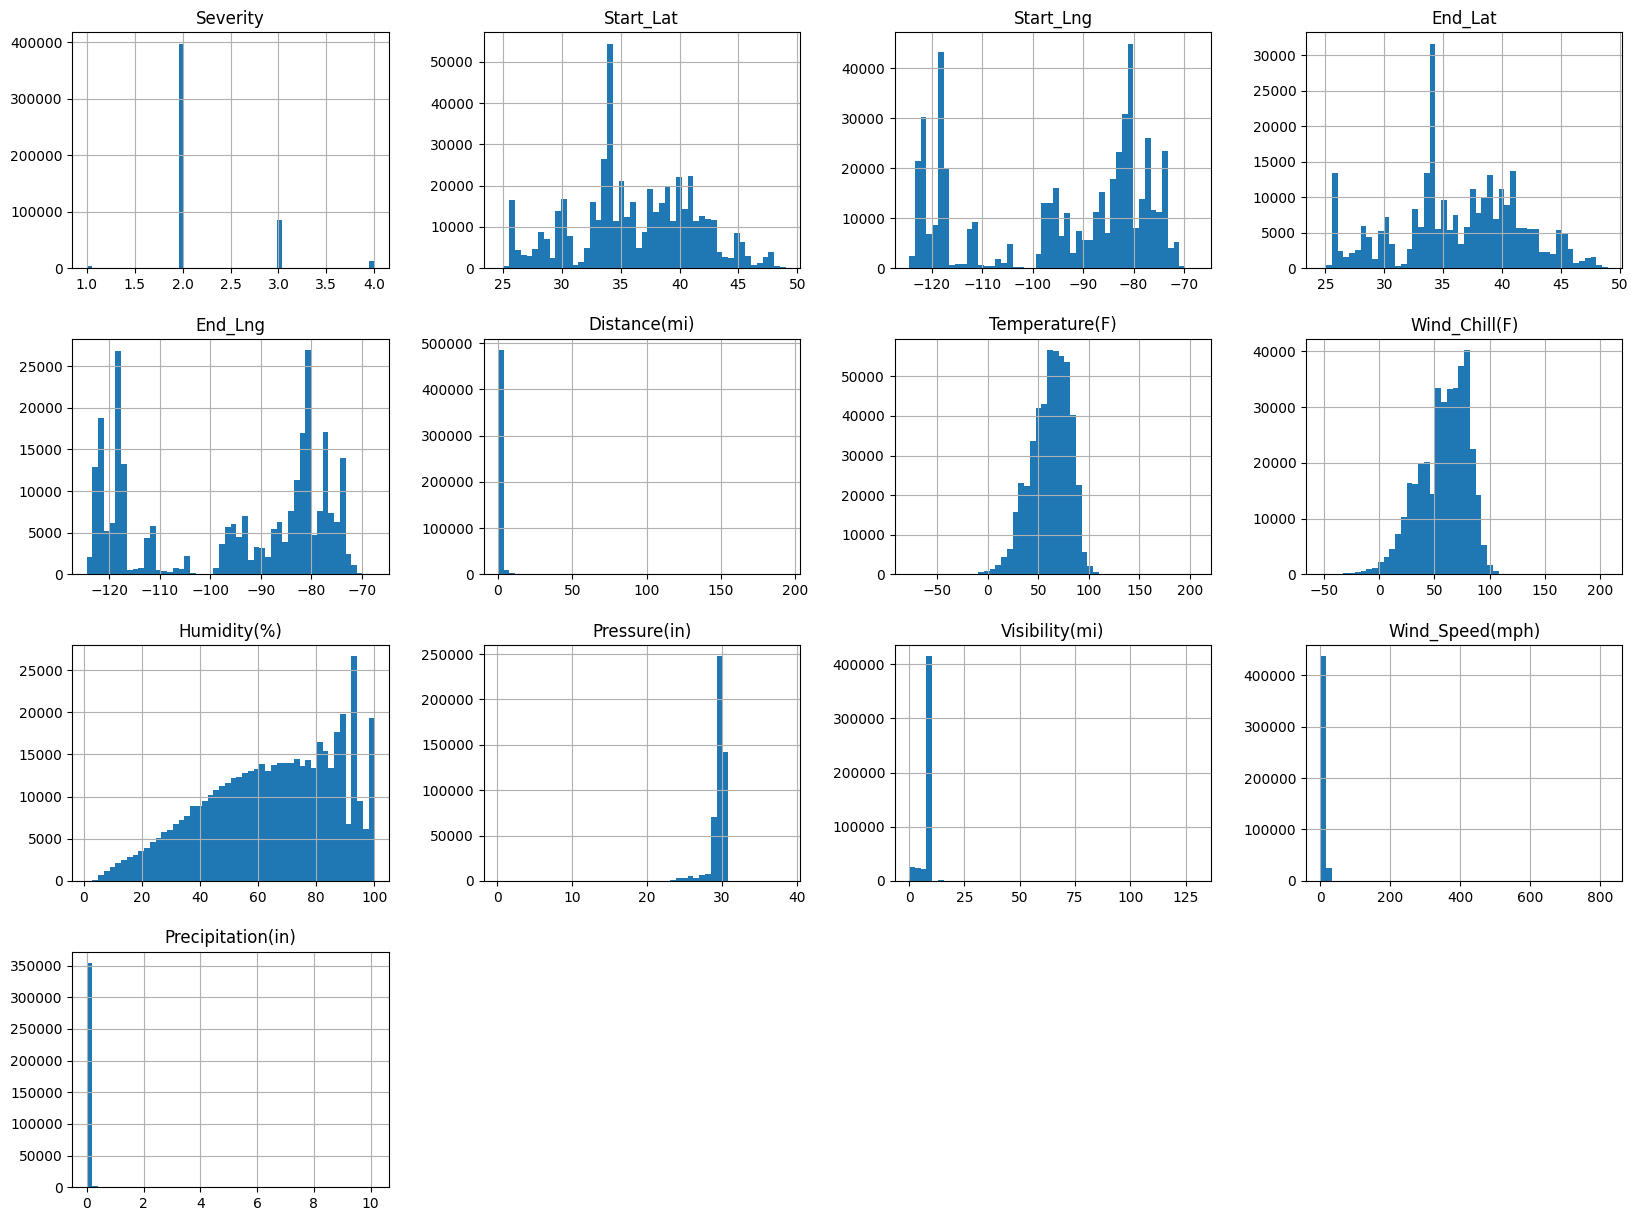

In [5]:
accidents.hist(bins=50, figsize=(20,15))

<Axes: >

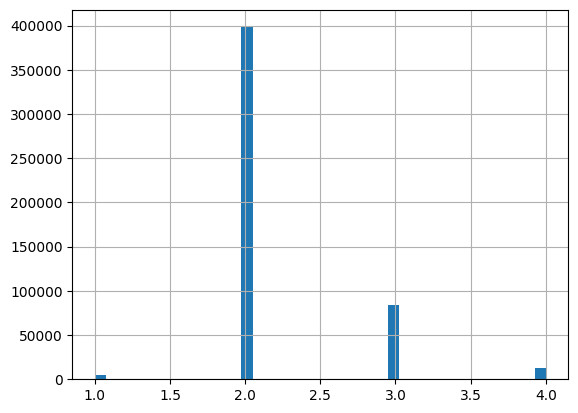

In [6]:
accidents["Severity"].hist(bins=40) 

In [7]:
accidents["Severity"].value_counts()

Severity
2    398142
3     84520
4     13064
1      4274
Name: count, dtype: int64

In [8]:
# Transform severity to binary, mapping 1 and 2 to 0 and 3 and 4 to 1
accidents["Severity_Binary"] = np.where(accidents["Severity"] <= 2, 0, 1)

# Drop the original severity column
accidents = accidents.drop(columns=["Severity"])

In [9]:
accidents["Severity_Binary"].value_counts()

Severity_Binary
0    402416
1     97584
Name: count, dtype: int64

<Axes: >

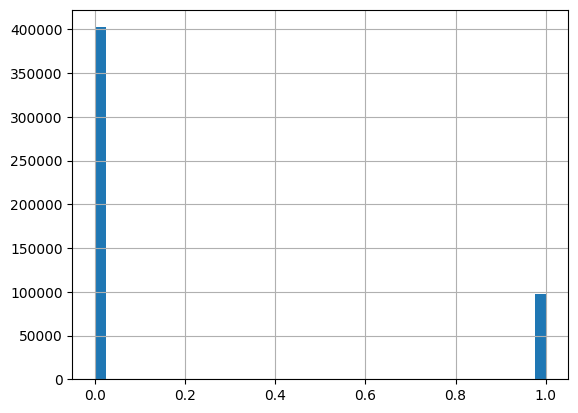

In [10]:
accidents["Severity_Binary"].hist(bins=40)

In [11]:
missing = accidents.isnull().sum().sum()
print(f"Missing values: {missing}")

percentage_missing = missing / (accidents.shape[0] * accidents.shape[1]) * 100
print(f"Percentage of missing values: {percentage_missing:.2f}%")

Missing values: 829873
Percentage of missing values: 3.61%


In [12]:
accidents.describe()

,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Severity_Binary
count,500000.000000,500000.000000,279623.000000,279623.000000,500000.000000,489534.000000,370983.000000,488870.000000,491072.000000,488709.000000,463013.000000,357384.000000,500000.000000
mean,36.206421,-94.736583,36.273192,-95.776553,0.564317,61.646254,58.229028,64.834921,29.536621,9.091540,7.681347,0.008289,0.195168
std,5.071411,17.405761,5.265333,18.120211,1.774872,19.000133,22.352246,22.826158,1.008666,2.708083,5.431361,0.101865,0.396330
min,24.562117,-124.497420,24.570110,-124.497419,0.000000,-77.800000,-53.200000,1.000000,0.120000,0.000000,0.000000,0.000000,0.000000
25%,33.416823,-117.233047,33.474773,-117.778324,0.000000,49.000000,43.000000,48.000000,29.370000,10.000000,4.600000,0.000000,0.000000
50%,35.832147,-87.794365,36.192669,-88.039013,0.029000,64.000000,62.000000,67.000000,29.860000,10.000000,7.000000,0.000000,0.000000
75%,40.082443,-80.359601,40.181341,-80.252449,0.465000,76.000000,75.000000,84.000000,30.030000,10.000000,10.400000,0.000000,0.000000
max,48.999569,-67.484130,48.998901,-67.484130,193.479996,207.000000,207.000000,100.000000,38.440000,130.000000,822.800000,10.130000,1.000000


Stratification
===========

In [13]:
# Binary classifier stratification for binary severity feature

X = accidents.drop(columns=['Severity_Binary'])
y = accidents['Severity_Binary']

# Split the dataset with stratification for classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Verify the distribution
print("Original distribution:", dict(zip(*np.unique(y, return_counts=True))))
print("Training distribution:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Testing distribution:", dict(zip(*np.unique(y_test, return_counts=True))))

Original distribution: {np.int64(0): np.int64(402416), np.int64(1): np.int64(97584)}
Training distribution: {np.int64(0): np.int64(321933), np.int64(1): np.int64(78067)}
Testing distribution: {np.int64(0): np.int64(80483), np.int64(1): np.int64(19517)}


Explore the Data
=============

Notes:
* I want lots of written information, the only code to keep when submitting is the code to output numbers, tables, or plots that you refer to in your writing
* During exploration, it is reasonable to remove unreasonable outliers (and document that you are doing so and how you are classifying what an outlier is) before doing further analysis
  * There are differences in outliers: ones that are real and ones that are errors. For example, if a height was entered as 7'1" for Shaq O'Neal, that is a real outlier, it has meaning. If a height was entered as 7'1" for a random person, that is an error. You should (try to) remove (only) the error/non-useful ones.
* You will need to explore how to work with date-times, Pandas has a very wide range of utilities for working with them, one particular thing to possibly use is extracting components of the date-time (like hours in the day or day-of-week)
* Document all important things, make sure to put headers for the separate steps, and keep everything organized

Reminder about the 9 steps (points in parentheses):
1. (1) Copy the data for exploration, downsampling to a manageable size if necessary.
2. (6) Study each attribute and its characteristics: Name; Type (categorical, numerical, bounded, text, structured, …); % of missing values; Noisiness and type of noise (stochastic, outliers, rounding errors, …); Usefulness for the task; Type of distribution (Gaussian, uniform, logarithmic, …) (format as a nice markdown table!)
3. (2) For supervised learning tasks, identify the target attribute(s)
4. (4) Visualize the data
5. (5) Study the correlations between attributes
6. (2) Study how you would solve the problem manually (using the data you have)
7. (3) Identify the promising transformations you may want to apply
8. (2) Identify extra data that would be useful (discuss it, but don't actually go through with it)
9. (0) Document what you have learned (included in the other steps - it is actually worth most of the points!)

In [14]:
X_combined = X_train.copy()

y_combined = y_train.copy()

In [37]:
from sklearn.feature_selection import VarianceThreshold

# Filter out non-numerical and non-boolean features
numerical_boolean_features = X_combined.select_dtypes(include=['number', 'bool'])

# Remove features with low variance
selector = VarianceThreshold(threshold=0.01)  # Adjust threshold as needed
selector.fit(numerical_boolean_features)

# Features that passed the threshold
low_variance_features = numerical_boolean_features.columns[~selector.get_support()]
print("Low variance features to drop:", low_variance_features)

# Update X_combined to only include features that passed the variance threshold
#X_combined = numerical_boolean_features.loc[:, selector.get_support()]

Low variance features to drop: Index(['Bump', 'Give_Way', 'No_Exit', 'Railway', 'Roundabout',
       'Traffic_Calming', 'Turning_Loop'],
      dtype='object')


In [40]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

# Filter out categorical features
categorical_features = X_combined.select_dtypes(include=['object'])

# Encode categorical features using LabelEncoder
encoded_features = pd.DataFrame()
for column in categorical_features.columns:
    le = LabelEncoder()
    encoded_features[column] = le.fit_transform(categorical_features[column])

# Compute chi2 scores for categorical features
chi_scores = chi2(encoded_features, y_train)

# Display scores
chi_scores_df = pd.DataFrame({'Feature': encoded_features.columns, 'Chi-Square Score': chi_scores[0]})
print(chi_scores_df.sort_values(by='Chi-Square Score', ascending=False))

                  Feature  Chi-Square Score
3                End_Time      2.193779e+09
2              Start_Time      2.156483e+09
13      Weather_Timestamp      1.095476e+09
0                      ID      6.571684e+08
5                  Street      4.743520e+07
4             Description      9.047580e+06
9                 Zipcode      5.789387e+06
6                    City      5.596337e+05
7                  County      3.631574e+05
12           Airport_Code      6.489217e+04
15      Weather_Condition      5.779195e+04
1                  Source      2.386416e+04
14         Wind_Direction      2.101215e+03
11               Timezone      9.255830e+02
8                   State      7.763828e+02
19  Astronomical_Twilight      1.166977e+02
18      Nautical_Twilight      6.948420e+01
17         Civil_Twilight      4.902559e+01
16         Sunrise_Sunset      3.131919e+01
10                Country               NaN


In [41]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

# Filter out categorical features
categorical_features = X_combined.select_dtypes(include=['object', 'category'])

# Encode categorical features using LabelEncoder
encoded_features = pd.DataFrame()
for column in categorical_features.columns:
    le = LabelEncoder()
    encoded_features[column] = le.fit_transform(categorical_features[column])

# Compute chi2 scores for categorical features
chi_scores = chi2(encoded_features, y_train)

# Display scores with formatting
chi_scores_df = pd.DataFrame({
    'Feature': encoded_features.columns,
    'Chi-Square Score': chi_scores[0]
})

# Format the Chi-Square Score to be more readable
chi_scores_df['Chi-Square Score'] = chi_scores_df['Chi-Square Score'].map('{:.2e}'.format)

print(chi_scores_df.sort_values(by='Chi-Square Score', ascending=False))

                  Feature Chi-Square Score
10                Country              nan
11               Timezone         9.26e+02
4             Description         9.05e+06
8                   State         7.76e+02
18      Nautical_Twilight         6.95e+01
0                      ID         6.57e+08
12           Airport_Code         6.49e+04
9                 Zipcode         5.79e+06
15      Weather_Condition         5.78e+04
6                    City         5.60e+05
17         Civil_Twilight         4.90e+01
5                  Street         4.74e+07
7                  County         3.63e+05
16         Sunrise_Sunset         3.13e+01
1                  Source         2.39e+04
3                End_Time         2.19e+09
2              Start_Time         2.16e+09
14         Wind_Direction         2.10e+03
19  Astronomical_Twilight         1.17e+02
13      Weather_Timestamp         1.10e+09


In [36]:
from sklearn.feature_selection import VarianceThreshold

# Remove features with low variance
selector = VarianceThreshold(threshold=0.01)  # Adjust threshold as needed
selector.fit(X_combined)

# Features that passed the threshold
low_variance_features = X_combined.columns[~selector.get_support()]
print("Low variance features to drop:", low_variance_features)

ValueError: could not convert string to float: 'A-6038198'

In [15]:
# Initialize and train the RandomForest model
model = RandomForestClassifier(random_state=42)
model.fit(X_combined, y_combined)

# Extract feature importances
feature_importances = model.feature_importances_

# Create a DataFrame with the feature names and their importance
feature_importances_df = pd.DataFrame(
    {"Feature": X_combined.columns, "Importance": feature_importances}
)

# Sort the Dataframe by importance
feature_importances_df = feature_importances_df.sort_values("Importance", ascending=False)

# Display the feature importances
print(feature_importances_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df["Feature"], feature_importances_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.gca().invert_yaxis()
plt.show()

ValueError: could not convert string to float: 'A-6038198'

In [16]:
data = pd.concat([X_combined, y_combined], axis=1)

In [ ]:
data

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400000 entries, 99896 to 476005
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     400000 non-null  object 
 1   Source                 400000 non-null  object 
 2   Start_Time             400000 non-null  object 
 3   End_Time               400000 non-null  object 
 4   Start_Lat              400000 non-null  float64
 5   Start_Lng              400000 non-null  float64
 6   End_Lat                223509 non-null  float64
 7   End_Lng                223509 non-null  float64
 8   Distance(mi)           400000 non-null  float64
 9   Description            399999 non-null  object 
 10  Street                 399437 non-null  object 
 11  City                   399987 non-null  object 
 12  County                 400000 non-null  object 
 13  State                  400000 non-null  object 
 14  Zipcode                399913 non-nul

array([[<Axes: title={'center': 'Start_Lat'}>,
        <Axes: title={'center': 'Start_Lng'}>,
        <Axes: title={'center': 'End_Lat'}>,
        <Axes: title={'center': 'End_Lng'}>],
       [<Axes: title={'center': 'Distance(mi)'}>,
        <Axes: title={'center': 'Temperature(F)'}>,
        <Axes: title={'center': 'Wind_Chill(F)'}>,
        <Axes: title={'center': 'Humidity(%)'}>],
       [<Axes: title={'center': 'Pressure(in)'}>,
        <Axes: title={'center': 'Visibility(mi)'}>,
        <Axes: title={'center': 'Wind_Speed(mph)'}>,
        <Axes: title={'center': 'Precipitation(in)'}>],
       [<Axes: title={'center': 'Severity_Binary'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

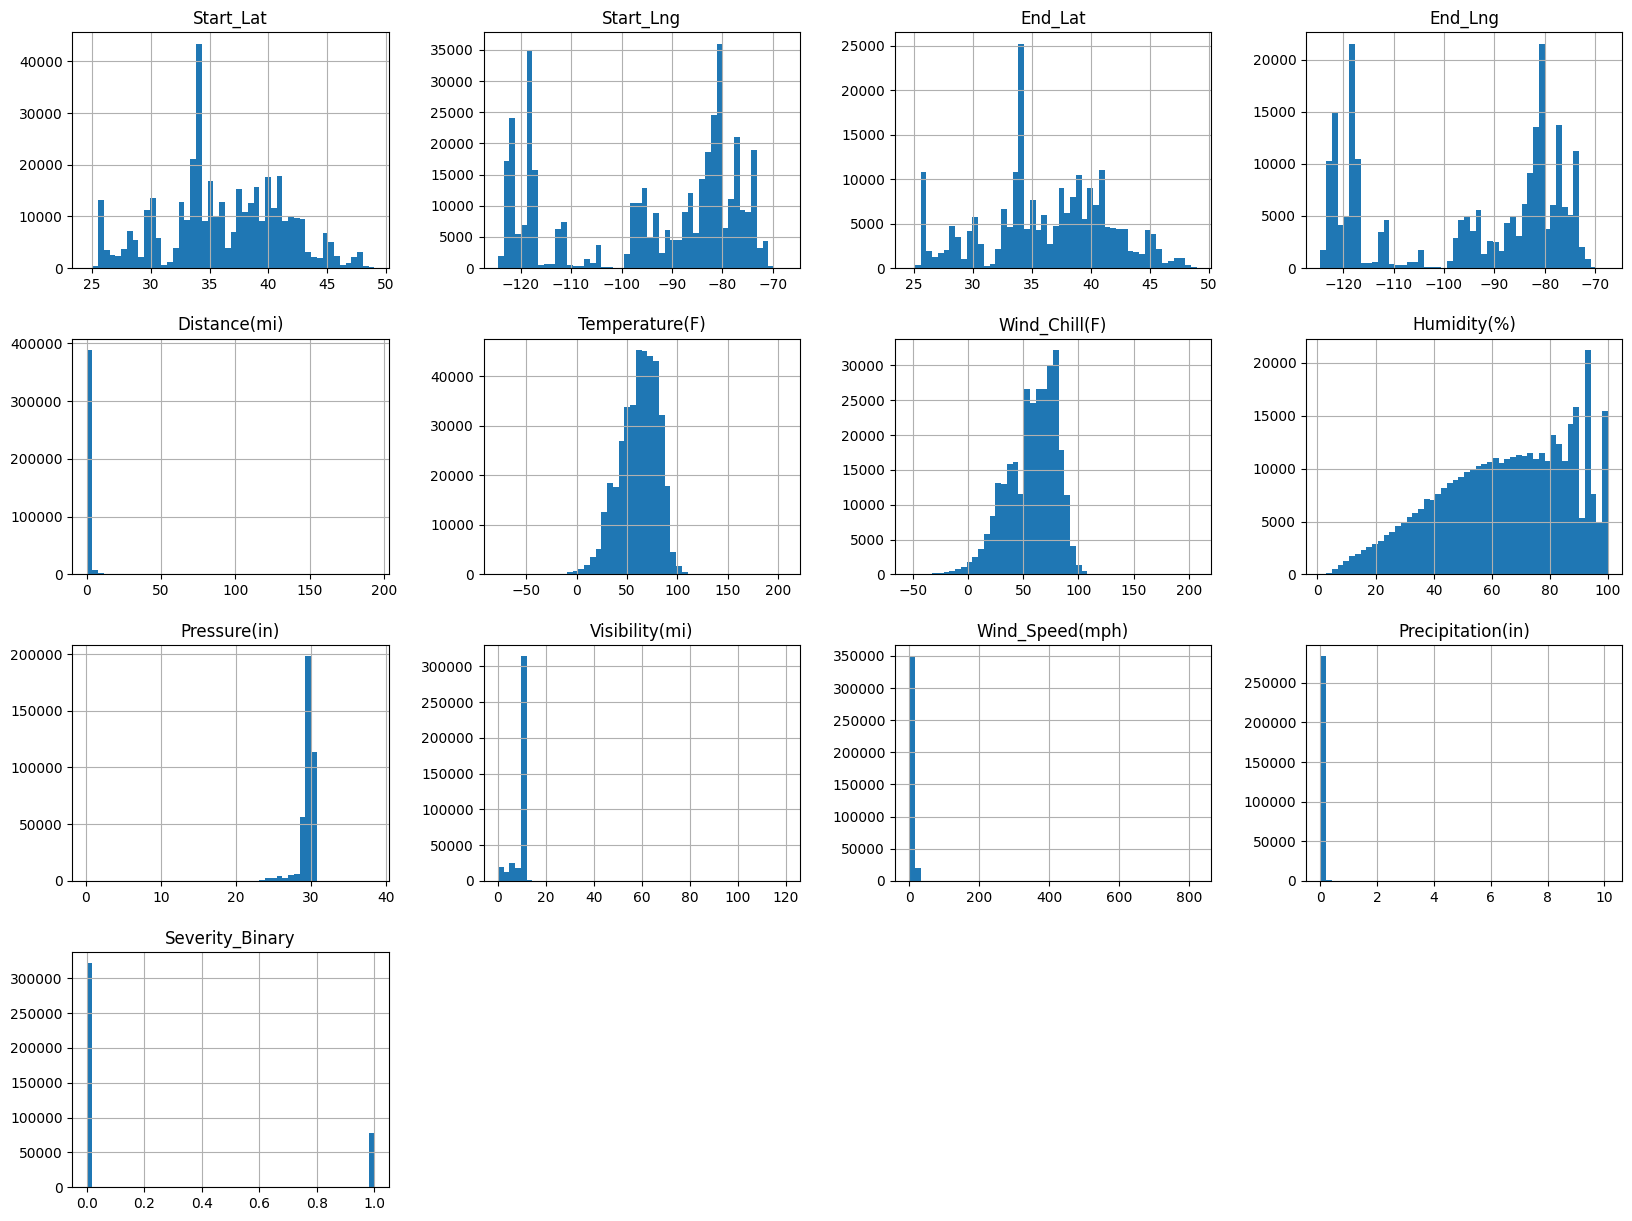

In [18]:
data.hist(bins=50, figsize=(20,15))

(np.int64(40), np.int64(32))

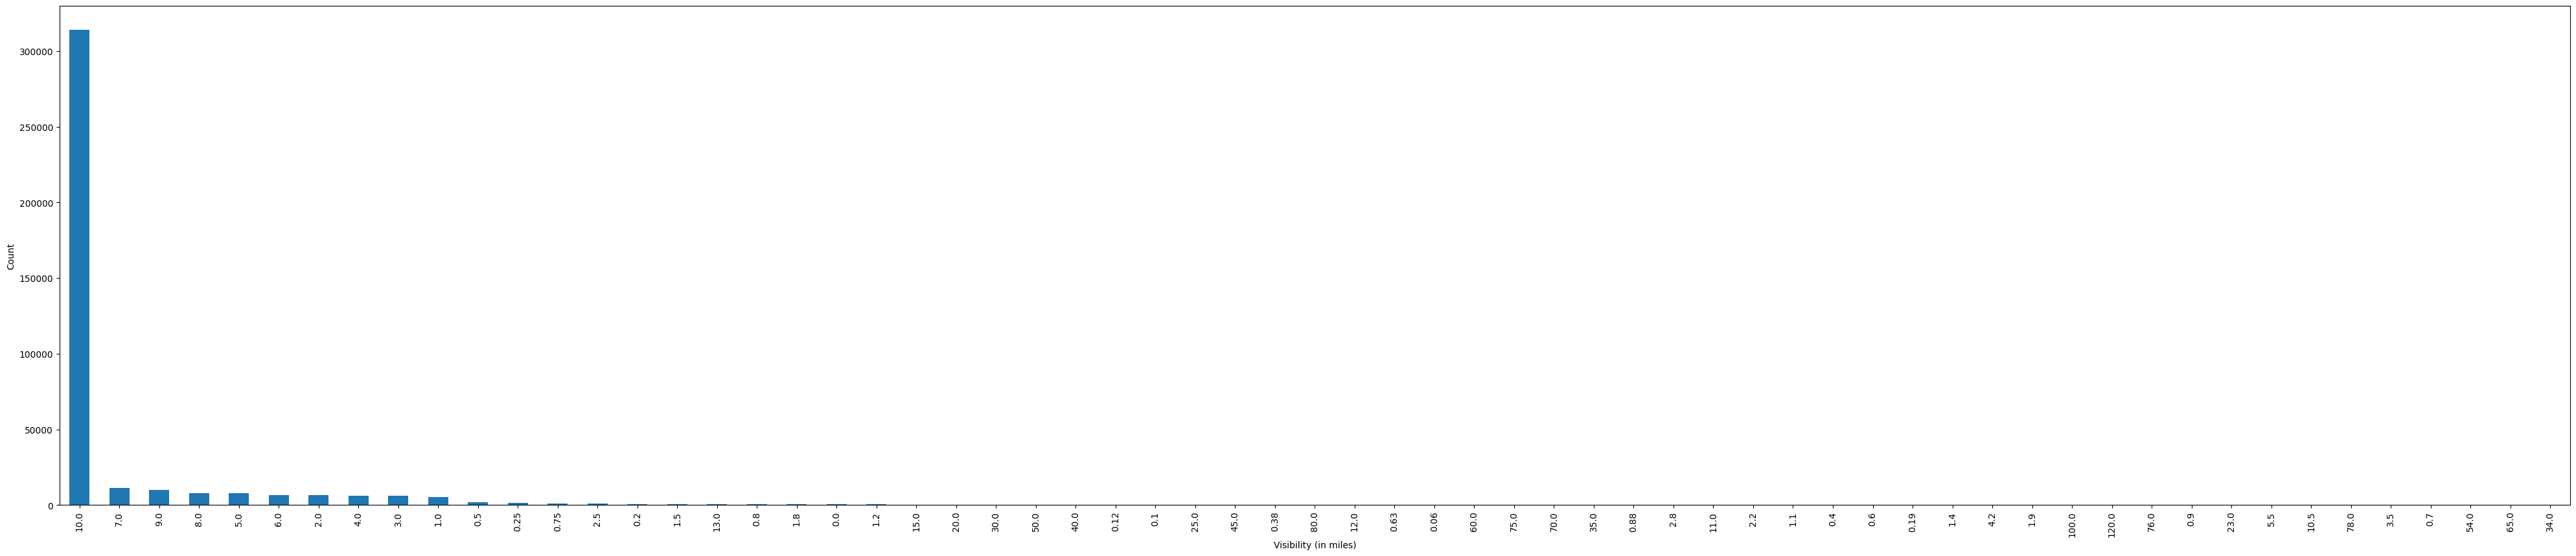

In [19]:
# Look at the distribution of Visibility
counts = data["Visibility(mi)"].value_counts()
counts.plot.bar(figsize=(50, 10))
plt.xlabel("Visibility (in miles)")
plt.ylabel("Count")
((counts / len(data) * 100) < 0.05).sum(), ((counts / len(data) * 100) < 0.005).sum()

(np.int64(54), np.int64(36))

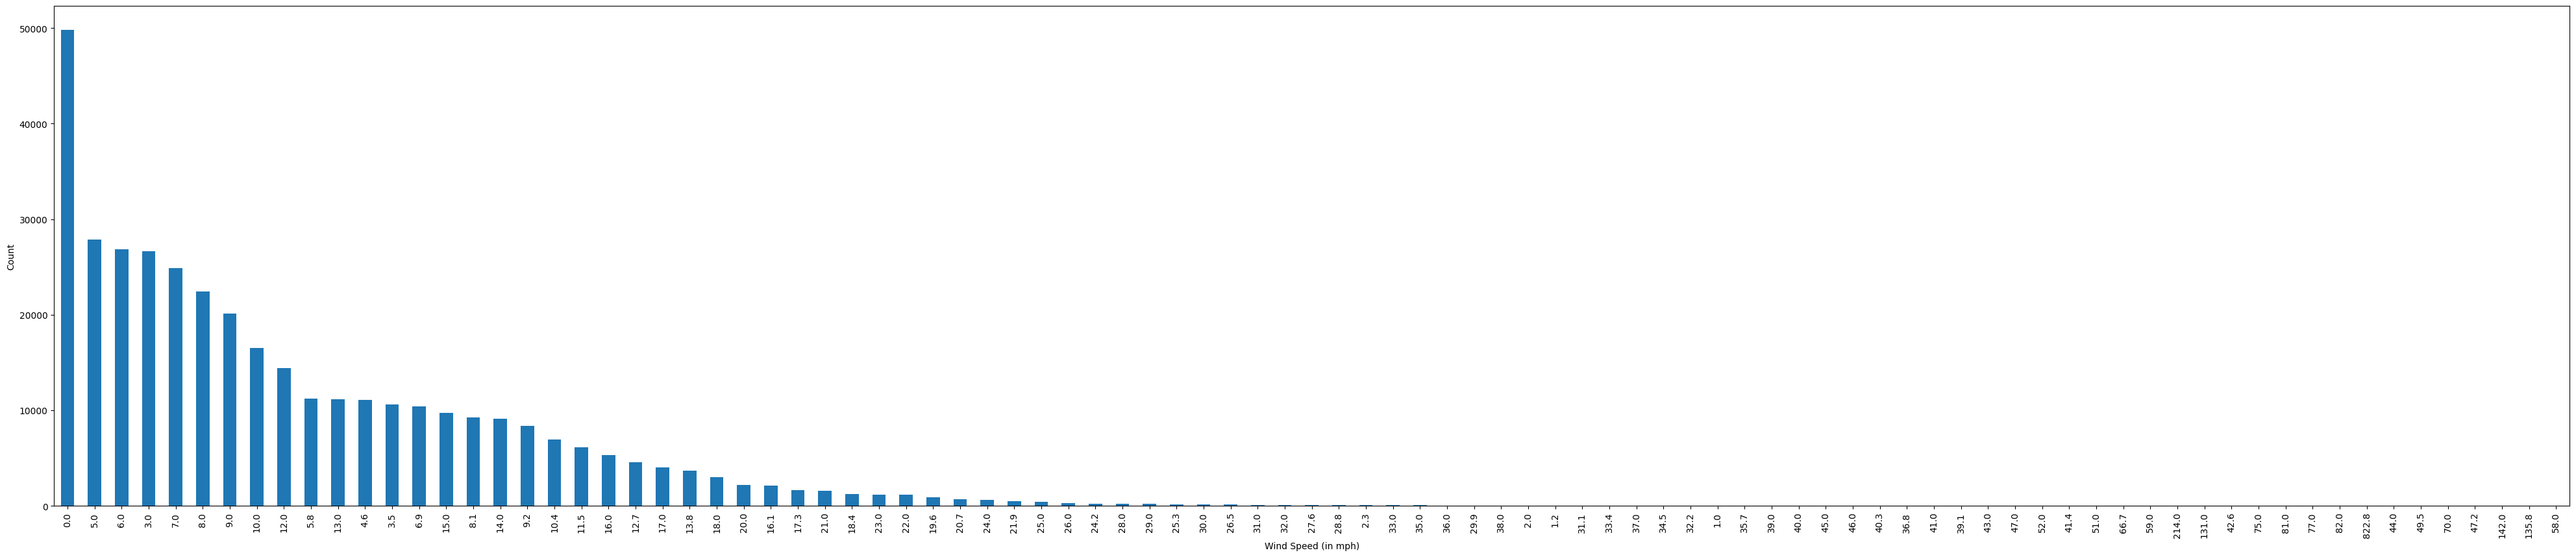

In [20]:
# Look at the distribution of Wind_Speed
counts = data["Wind_Speed(mph)"].value_counts()
counts.plot.bar(figsize=(50, 10))
plt.xlabel("Wind Speed (in mph)")
plt.ylabel("Count")
((counts / len(data) * 100) < 0.05).sum(), ((counts / len(data) * 100) < 0.005).sum()

(np.int64(538), np.int64(360))

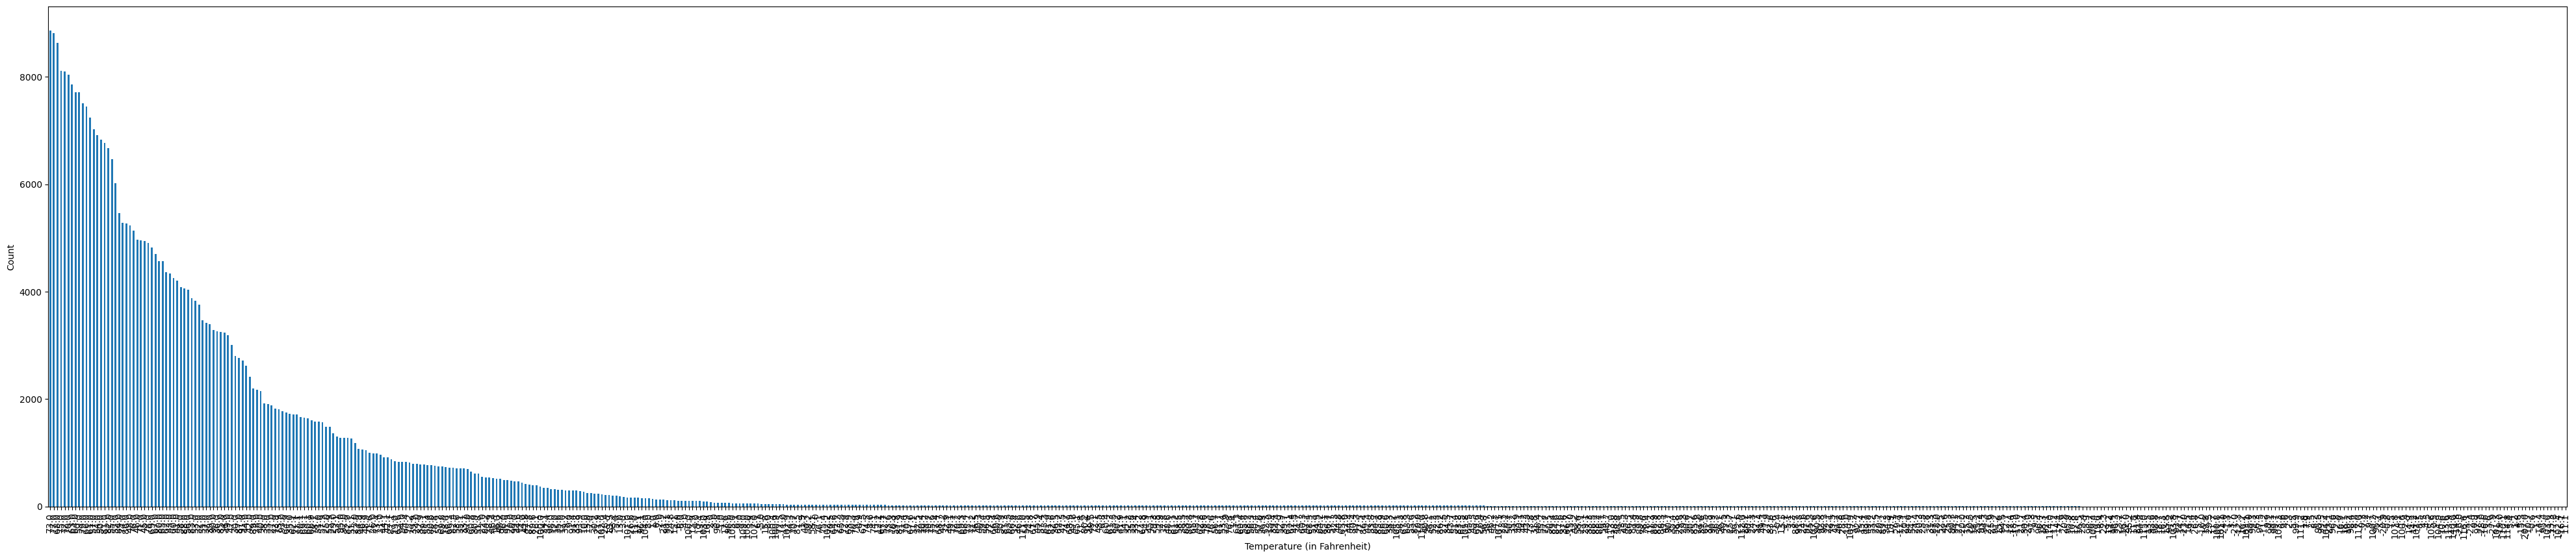

In [21]:
# Look at the distribution of Temperature
counts = data["Temperature(F)"].value_counts()
counts.plot.bar(figsize=(50, 10))
plt.xlabel("Temperature (in Fahrenheit)")
plt.ylabel("Count")
((counts / len(data) * 100) < 0.05).sum(), ((counts / len(data) * 100) < 0.005).sum()

(np.int64(4), np.int64(2))

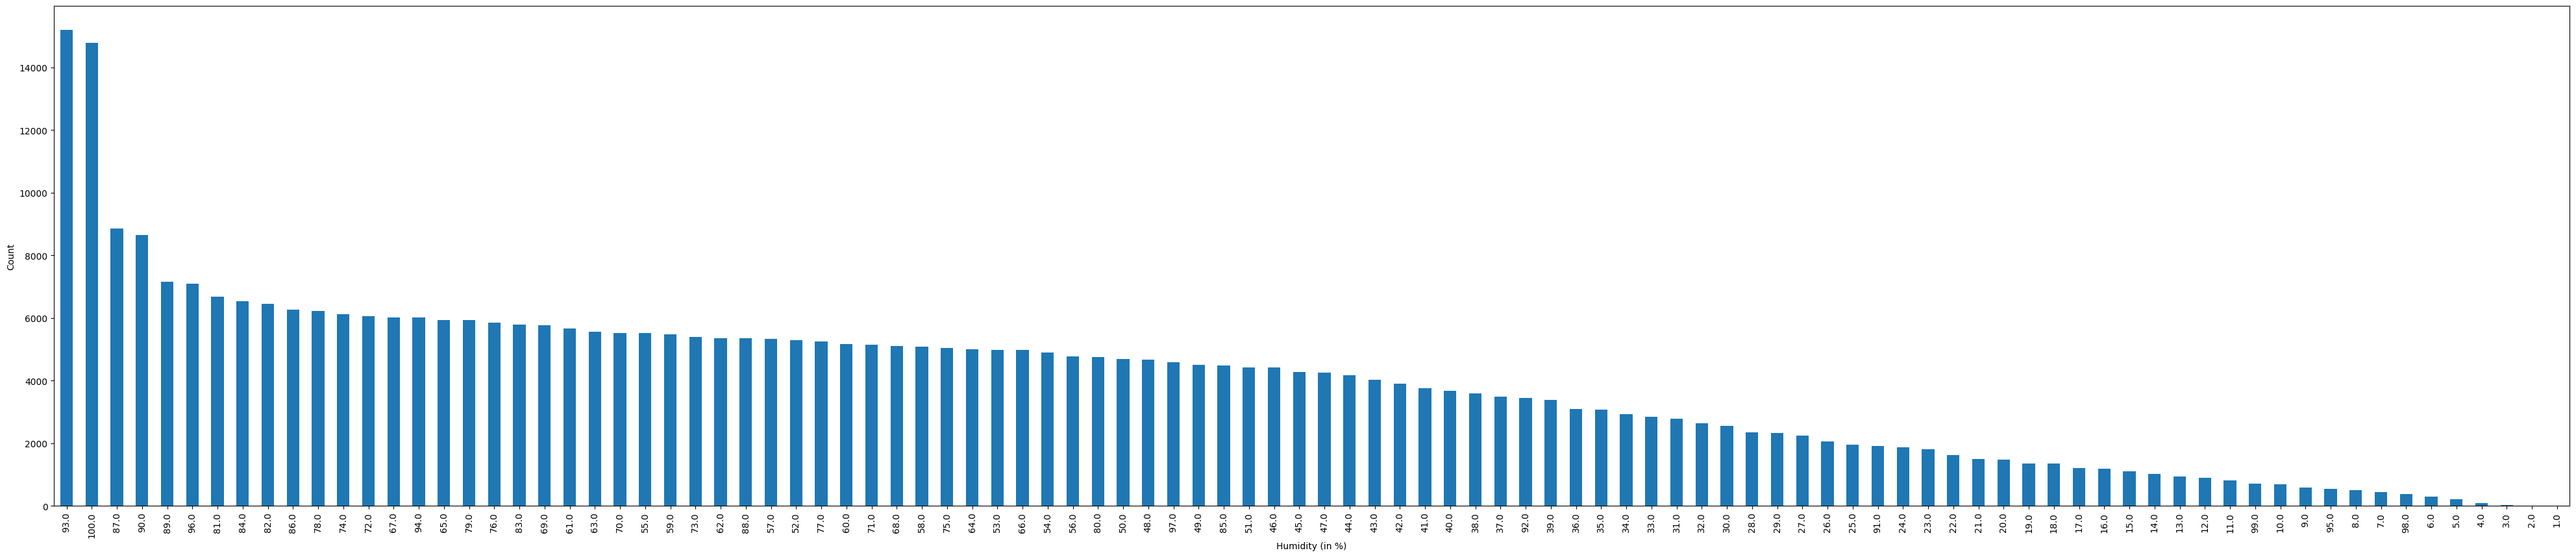

In [22]:
# Look at the distribution of Humidity
counts = data["Humidity(%)"].value_counts()
counts.plot.bar(figsize=(50, 10))
plt.xlabel("Humidity (in %)")
plt.ylabel("Count")
((counts / len(data) * 100) < 0.05).sum(), ((counts / len(data) * 100) < 0.005).sum()

<Axes: xlabel='Temperature(F)', ylabel='Severity_Binary'>

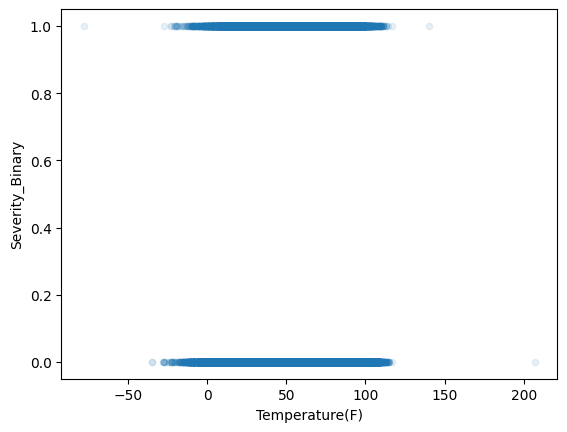

In [23]:
# Compare severity with temperature
data.plot(kind="scatter", x="Temperature(F)", y="Severity_Binary", alpha=0.1)

<Axes: title={'center': 'Temperature(F)'}, xlabel='Severity_Binary'>

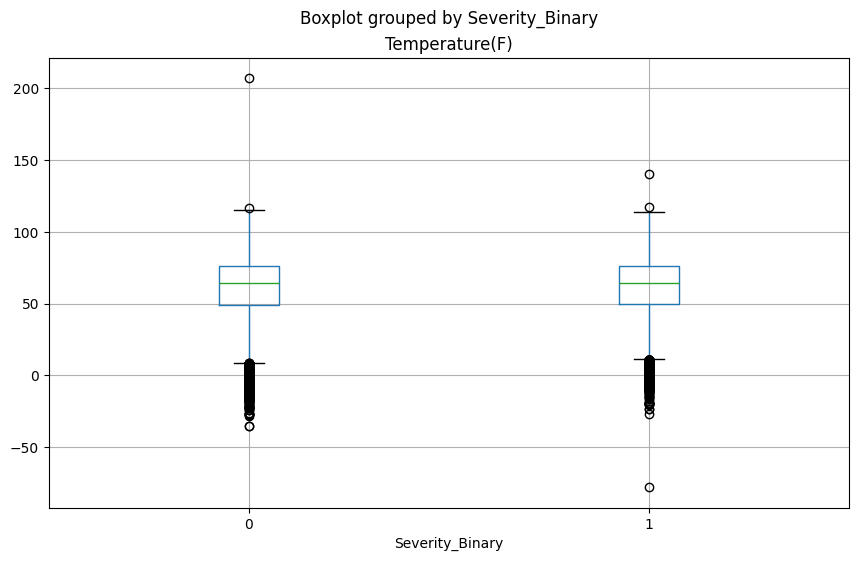

In [24]:
# compare severity with state using a boxplot
data.boxplot(column="Temperature(F)", by="Severity_Binary", figsize=(10, 6))



<Axes: xlabel='Severity_Binary'>

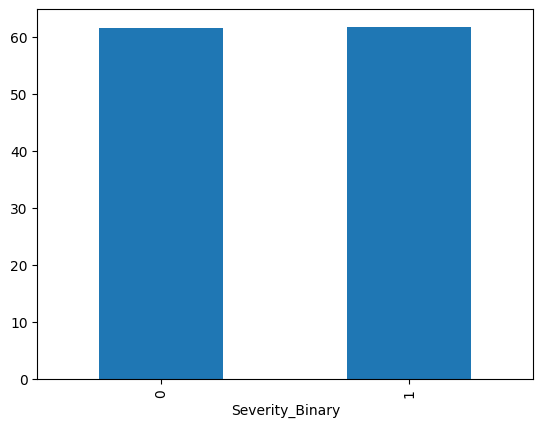

In [25]:
# Compare severity with state using a barplot
data.groupby("Severity_Binary")["Temperature(F)"].mean().plot(kind="bar")


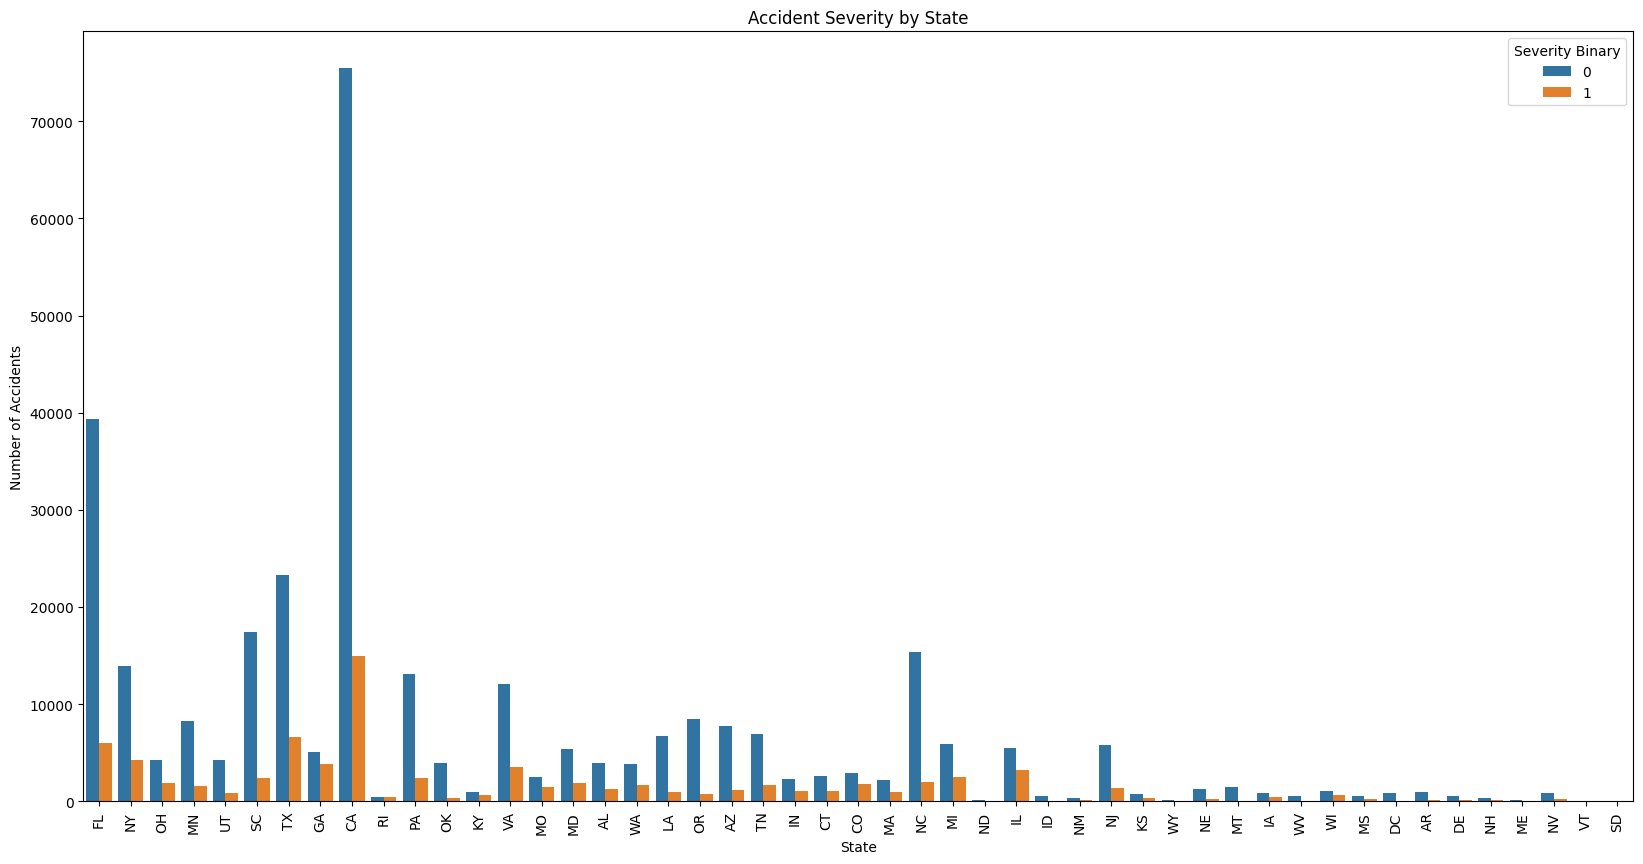

In [26]:
plt.figure(figsize=(20, 10))
sns.countplot(data=data, x='State', hue='Severity_Binary')
plt.title('Accident Severity by State')
plt.xlabel('State')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity Binary')
plt.xticks(rotation=90)
plt.show()

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400000 entries, 99896 to 476005
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     400000 non-null  object 
 1   Source                 400000 non-null  object 
 2   Start_Time             400000 non-null  object 
 3   End_Time               400000 non-null  object 
 4   Start_Lat              400000 non-null  float64
 5   Start_Lng              400000 non-null  float64
 6   End_Lat                223509 non-null  float64
 7   End_Lng                223509 non-null  float64
 8   Distance(mi)           400000 non-null  float64
 9   Description            399999 non-null  object 
 10  Street                 399437 non-null  object 
 11  City                   399987 non-null  object 
 12  County                 400000 non-null  object 
 13  State                  400000 non-null  object 
 14  Zipcode                399913 non-nul

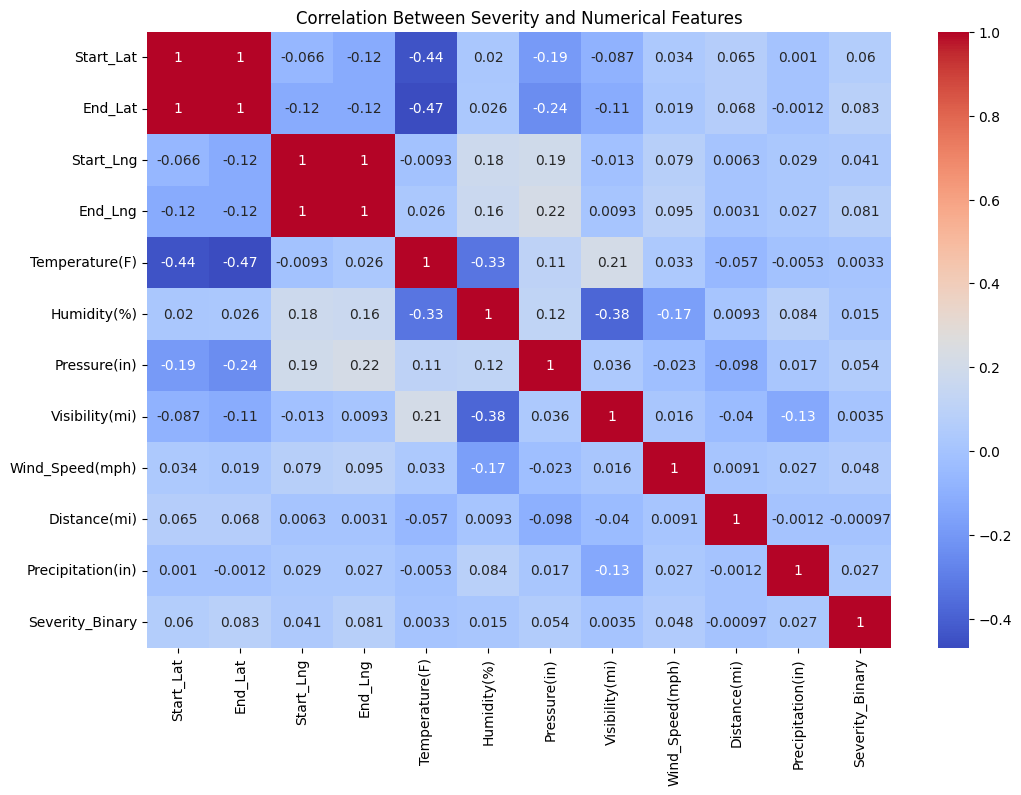

In [33]:
attrs = ["Start_Lat", "End_Lat", "Start_Lng", "End_Lng", "Temperature(F)", "Humidity(%)", "Pressure(in)", 
         "Visibility(mi)", "Wind_Speed(mph)", "Distance(mi)", "Precipitation(in)", "Severity_Binary"]
corr_matrix = data[attrs].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Between Severity and Numerical Features")
plt.show()

Turning loop contains all false values, so it doesn't tell us much = should be removed

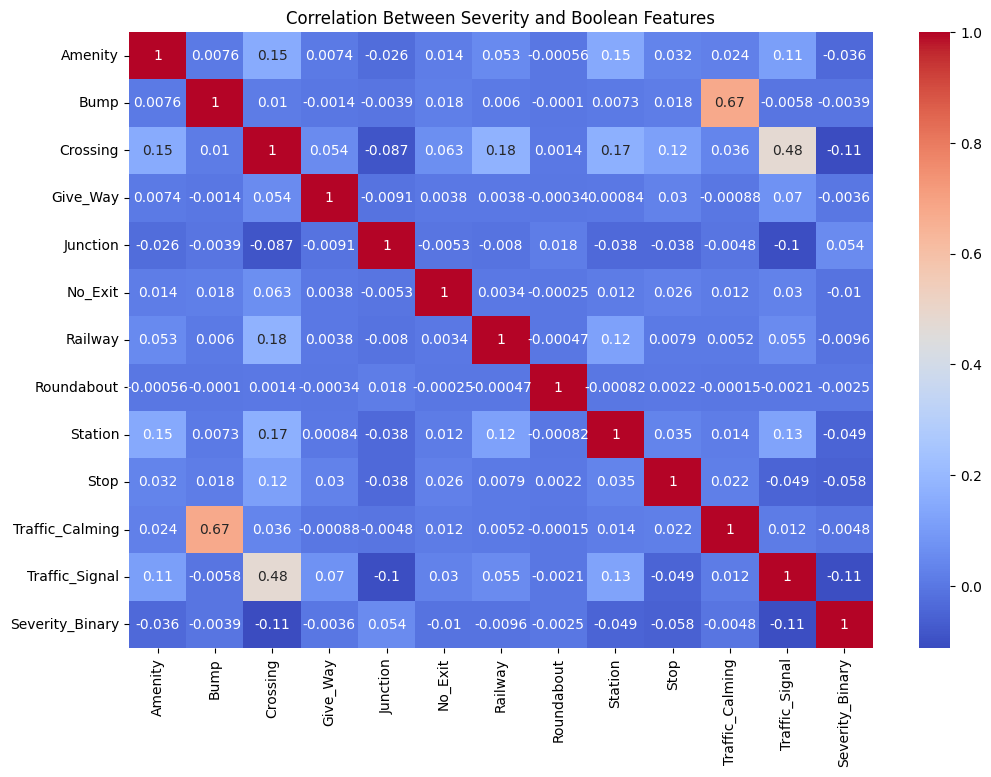

In [35]:
bool_attrs = ["Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit",
          "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Severity_Binary"]

corr_matrix2 = data[bool_attrs].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm')
plt.title("Correlation Between Severity and Boolean Features")
plt.show()

In [ ]:
# Distances and Durations Correlation - decent linear correlation: .81
scatter_plot(
    'Distance (unknown units)', data['dist'],
    'Duration (minutes)', data['duration'] / 60,
    extra = lambda: plt.ylim(0, 150)
)
corr('dist', 'duration')